In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy.io as sio
import anndata as ad
import seaborn as sns
import os as os
import sys as sys
sys.path.append('/home/qiuaodon/Desktop/PanCancer_scRNA_analysis/utils/')
from scRNA_utils import *
import operator as op
import matplotlib.colors as mcolors

In [2]:
data_dir_NHDP = "/home/qiuaodon/Desktop/project_data_new/"
adata_T = sc.read(data_dir_NHDP + '1863-counts_cells_cohort1_T_cells.h5ad')
adata_1 = adata_T[adata_T.obs['leiden'] == '4', :]
adata_B = sc.read(data_dir_NHDP + '1863-counts_cells_cohort1_B_cells.h5ad')
adata_2 = adata_B

In [3]:
adata_1_pseudo = scRNA2PseudoBulkAnnData(adata_1, sample_id_col='sample_id')
adata_2_pseudo = scRNA2PseudoBulkAnnData(adata_2, sample_id_col='sample_id')

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# because some samples are missing, we need to add them to the dataset
# to make sure nosamplefiltered
from scRNA_utils import add_missing_samples
import anndata
# Extract sample_ids
sample_ids_1 = set(adata_1_pseudo.obs['sample_id'])
sample_ids_2 = set(adata_2_pseudo.obs['sample_id'])

# Identify missing sample_ids
missing_sample_ids_1 = sample_ids_2 - sample_ids_1
missing_sample_ids_2 = sample_ids_1 - sample_ids_2

# Add missing sample_ids to each dataset
adata_1_pseudo = add_missing_samples(adata_1_pseudo, missing_sample_ids_1)
adata_2_pseudo = add_missing_samples(adata_2_pseudo, missing_sample_ids_2)
# Sort the obs DataFrame by sample_id in both AnnData objects
adata_1_pseudo = adata_1_pseudo[adata_1_pseudo.obs.sort_values('sample_id').index]
adata_2_pseudo = adata_2_pseudo[adata_2_pseudo.obs.sort_values('sample_id').index]

# Verify that both datasets have the same sample_ids and in the same order
assert (adata_1_pseudo.obs['sample_id'].values == adata_2_pseudo.obs['sample_id'].values).all()

# Now adata_T_pseudo and adata_Endo_pseudo have the same sample_ids in the same order

/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, n

In [5]:
adata_1_pseudo.raw = adata_1_pseudo
adata_2_pseudo.raw = adata_2_pseudo

In [6]:
DEG_1 = paird_ttest(adata_1, condition_key = 'timepoint', sample_id_col = 'sample_id', patient_id_col = 'patient_id')
DEG_2 = paird_ttest(adata_2, condition_key = 'timepoint', sample_id_col = 'sample_id', patient_id_col = 'patient_id')

Input adata is not pseudo-bulk RNA data. Convert to pseudo-bulk RNA data.


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Input adata is not pseudo-bulk RNA data. Convert to pseudo-bulk RNA data.


/home/qiuaodon/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
DEG_1 = DEG_1[DEG_1['pval'] < 0.05]
DEG_2 = DEG_2[DEG_2['pval'] < 0.05]
gene_1 = DEG_1.index.tolist()
gene_2 = DEG_2.index.tolist()

# Filter out invalid gene names
gene_1 = [gene for gene in gene_1 if gene in adata_1_pseudo.var_names]
gene_2 = [gene for gene in gene_2 if gene in adata_2_pseudo.var_names]

gene_1_matrix = adata_1_pseudo[:, gene_1].X
gene_2_matrix = adata_2_pseudo[:, gene_2].X
gene_1_df = pd.DataFrame(gene_1_matrix, columns=gene_1, index=adata_1_pseudo.obs['sample_id'])
gene_2_df = pd.DataFrame(gene_2_matrix, columns=gene_2, index=adata_2_pseudo.obs['sample_id'])
gene_1_df.columns = [i + '_CD8EX' for i in gene_1_df.columns]
gene_2_df.columns = [i + '_B' for i in gene_2_df.columns]
gene_df = gene_1_df
gene_df = pd.merge(gene_df, gene_2_df, on='sample_id')

In [8]:
gene_df['treatment'] = gene_df.index.str.contains('On').astype(int)
# get patient id from sample id remove the _On or _Pre
gene_df['patient_id'] = gene_df.index.str.replace('_On', '').str.replace('_Pre', '')
gene_df['treatment'].value_counts()

1    31
0    31
Name: treatment, dtype: int64

# 0927

In [9]:
results = pd.read_excel('/home/qiuaodon/Desktop/project_data_new/CIT_results_CD8EXvsB_fisherz_nosamplefiltered.xlsx')

In [10]:
# only keep the significant results with correlation > 0.3 or < -0.3
results = results[(results['g1vsg2_correlation'] > 0.3)]

In [11]:
calculate_g1_L_correlation(results, adata_1_pseudo)
calculate_g2_R_correlation(results, adata_2_pseudo)

,Unnamed: 0,g1,g2,L,R,pValue,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,g1vsL_correlation,g2vsR_correlation
0,0,NFKBIA_T,CEMIP2_B,ANXA1,CCR7,0.684811,0.357811,0.053248,0.449228,0.778998
1,1,NFKBIA_T,CEMIP2_B,CCL5,CCR7,0.100315,0.357811,0.212492,0.365575,0.778998
2,2,TXNIP_T,CEMIP2_B,ANXA1,CCR7,0.253079,0.352102,0.148954,0.395721,0.778998
3,3,TXNIP_T,CEMIP2_B,CCL5,CCR7,0.222669,0.352102,0.158769,0.316406,0.778998
4,4,NFKBIA_T,SOCS1_B,ANXA1,CCR7,0.243642,0.334328,0.151909,0.449228,0.414003
5,5,NFKBIA_T,SOCS1_B,CCL5,CCR7,0.060472,0.334328,0.241631,0.365575,0.414003
6,6,TSC22D3_T,CEMIP2_B,ANXA1,CCR7,0.697480,0.317250,0.050998,0.533547,0.778998
7,7,TSC22D3_T,CEMIP2_B,CCL5,CCR7,0.081744,0.317250,0.224661,0.359680,0.778998
8,8,TXNIP_T,AC025164.1_B,CXCL13,CCR7,0.056107,0.302802,0.245691,0.166652,0.417114
9,9,TXNIP_T,AC025164.1_B,ANXA1,P2RY14,0.118398,0.302802,0.202213,0.395721,0.541034


In [12]:
# remove the rows with g1vsL_correlation < 0.3 
results = results[(results['g1vsL_correlation'] > 0.2) & (results['g1vsL_correlation'] < 0.99)]
# remove the rows with g2vsR_correlation < 0.3 
results = results[(results['g2vsR_correlation'] > 0.2) & (results['g2vsR_correlation'] < 0.99)]
results

,Unnamed: 0,g1,g2,L,R,pValue,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,g1vsL_correlation,g2vsR_correlation
0,0,NFKBIA_T,CEMIP2_B,ANXA1,CCR7,0.684811,0.357811,0.053248,0.449228,0.778998
1,1,NFKBIA_T,CEMIP2_B,CCL5,CCR7,0.100315,0.357811,0.212492,0.365575,0.778998
2,2,TXNIP_T,CEMIP2_B,ANXA1,CCR7,0.253079,0.352102,0.148954,0.395721,0.778998
3,3,TXNIP_T,CEMIP2_B,CCL5,CCR7,0.222669,0.352102,0.158769,0.316406,0.778998
4,4,NFKBIA_T,SOCS1_B,ANXA1,CCR7,0.243642,0.334328,0.151909,0.449228,0.414003
5,5,NFKBIA_T,SOCS1_B,CCL5,CCR7,0.060472,0.334328,0.241631,0.365575,0.414003
6,6,TSC22D3_T,CEMIP2_B,ANXA1,CCR7,0.697480,0.317250,0.050998,0.533547,0.778998
7,7,TSC22D3_T,CEMIP2_B,CCL5,CCR7,0.081744,0.317250,0.224661,0.359680,0.778998
9,9,TXNIP_T,AC025164.1_B,ANXA1,P2RY14,0.118398,0.302802,0.202213,0.395721,0.541034
10,10,TXNIP_T,AC025164.1_B,CCL5,CCR7,0.092783,0.302802,0.217197,0.316406,0.417114


In [13]:
results['g1'] = results['g1'].str.replace(r'_\w+', '', regex=True)
results['g2'] = results['g2'].str.replace(r'_\w+', '', regex=True)
results

,Unnamed: 0,g1,g2,L,R,pValue,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,g1vsL_correlation,g2vsR_correlation
0,0,NFKBIA,CEMIP2,ANXA1,CCR7,0.684811,0.357811,0.053248,0.449228,0.778998
1,1,NFKBIA,CEMIP2,CCL5,CCR7,0.100315,0.357811,0.212492,0.365575,0.778998
2,2,TXNIP,CEMIP2,ANXA1,CCR7,0.253079,0.352102,0.148954,0.395721,0.778998
3,3,TXNIP,CEMIP2,CCL5,CCR7,0.222669,0.352102,0.158769,0.316406,0.778998
4,4,NFKBIA,SOCS1,ANXA1,CCR7,0.243642,0.334328,0.151909,0.449228,0.414003
5,5,NFKBIA,SOCS1,CCL5,CCR7,0.060472,0.334328,0.241631,0.365575,0.414003
6,6,TSC22D3,CEMIP2,ANXA1,CCR7,0.697480,0.317250,0.050998,0.533547,0.778998
7,7,TSC22D3,CEMIP2,CCL5,CCR7,0.081744,0.317250,0.224661,0.359680,0.778998
9,9,TXNIP,AC025164.1,ANXA1,P2RY14,0.118398,0.302802,0.202213,0.395721,0.541034
10,10,TXNIP,AC025164.1,CCL5,CCR7,0.092783,0.302802,0.217197,0.316406,0.417114


In [14]:
# get the unique (L,R) pairs in results
lr_pairs = results[['L', 'R']]
# remove the LR pairs repeated less than 3 times in the lr_pairs
lr_pairs = lr_pairs.groupby(['L', 'R']).filter(lambda x: len(x) >= 1)
lr_pairs = lr_pairs.drop_duplicates()
lr_pairs

,L,R
0,ANXA1,CCR7
1,CCL5,CCR7
9,ANXA1,P2RY14
12,ITGB1,JAM3
13,ITGA4,JAM3
14,CCL5,CNR2
15,CCL5,GPR18
20,ITGAM,JAM3


In [15]:
import pandas as pd
grouped_results = results.groupby(["L", "R"])

# Display grouped data
grouped_dict = { (ligand, receptor): group for (ligand, receptor), group in grouped_results }

# Create a new DataFrame to hold the GEM1 and GEM2 groupings
grouped_data = []
tracked_gem1 = set()
tracked_gem2 = set()

min_gene_num = 1

# Temporary list to hold data before creating DataFrame
temp_data = []

for (ligand, receptor), group in grouped_results:
    gem1 = group["g1"].drop_duplicates().tolist()
    gem2 = group["g2"].drop_duplicates().tolist()
    
    # Check the overlap between current GEM_g1 and previously tracked GEM_g1
    overlap_gem1 = len(set(gem1) & tracked_gem1)
    overlap_gem2 = len(set(gem2) & tracked_gem2)
    
    # Filter to include only those with at least three genes in GEM_g1 and GEM_g2
    # and where the overlap is below the maximum allowable threshold
    if len(gem1) > min_gene_num and len(gem2) > min_gene_num:
        temp_data.append({
            "L": ligand,
            "R": receptor,
            "g1": gem1,
            "g2": gem2,
            "Num_genes_g1": len(gem1),
            "Num_genes_g2": len(gem2)
        })
        # Update the tracked GEM_g1 and GEM_g2 sets
        tracked_gem1.update(gem1)
        tracked_gem2.update(gem2)

# Convert the temporary data to a DataFrame
grouped_df = pd.DataFrame(temp_data)

# Function to find overlapping rows
def find_overlapping_rows(df, column_name):
    overlap_info = []
    for index, row in df.iterrows():
        current_set = set(row[column_name])
        overlapping_rows = []
        for other_index, other_row in df.iterrows():
            if index != other_index:
                other_set = set(other_row[column_name])
                overlap = len(current_set & other_set)
                if overlap > len(current_set) / 3: # Set the threshold for overlap
                    overlapping_rows.append(other_index)
        overlap_info.append(overlapping_rows)
    return overlap_info

# Add columns for overlapping rows in GEM_g1 and GEM_g2
grouped_df["Overlapping_g1"] = find_overlapping_rows(grouped_df, "g1")
grouped_df["Overlapping_g2"] = find_overlapping_rows(grouped_df, "g2")


In [16]:
# rank each GEM_g1 by order of name inside
grouped_df['g1'] = grouped_df['g1'].apply(lambda x: sorted(x))
grouped_df['g2'] = grouped_df['g2'].apply(lambda x: sorted(x))
grouped_df

,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2
0,ANXA1,CCR7,"[NFKBIA, TSC22D3, TXNIP]","[CEMIP2, SOCS1]",3,2,"[1, 2, 3]",[1]
1,CCL5,CCR7,"[NFKBIA, TSC22D3, TXNIP]","[AC025164.1, CEMIP2, SOCS1]",3,3,"[0, 2, 3]",[0]
2,ITGA4,JAM3,"[TSC22D3, TXNIP]","[AC025164.1, KLF9]",2,2,"[0, 1, 3]","[1, 3]"
3,ITGB1,JAM3,"[TSC22D3, TXNIP]","[AC025164.1, KLF9]",2,2,"[0, 1, 2]","[1, 2]"


In [17]:
# remove '-0' and '-1' in adata_1_pseudo.obs.index
adata_1_pseudo.obs.index = [i.split('-')[0] for i in adata_1_pseudo.obs.index]
adata_2_pseudo.obs.index = [i.split('-')[0] for i in adata_2_pseudo.obs.index]

In [18]:
#calculate the correlation between g1 and g2
calculate_GEM_correlation(grouped_df, adata_1_pseudo, adata_2_pseudo)
#calculate the residuals correlation between g1, g2 and LR
calculate_residuals_GEM_correlation(grouped_df, adata_1_pseudo, adata_2_pseudo)

,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1vsg2_correlation,g1_residualvsg2_residuals_correlation
0,ANXA1,CCR7,"[NFKBIA, TSC22D3, TXNIP]","[CEMIP2, SOCS1]",3,2,"[1, 2, 3]",[1],0.372389,0.074970
1,CCL5,CCR7,"[NFKBIA, TSC22D3, TXNIP]","[AC025164.1, CEMIP2, SOCS1]",3,3,"[0, 2, 3]",[0],0.432618,0.289760
2,ITGA4,JAM3,"[TSC22D3, TXNIP]","[AC025164.1, KLF9]",2,2,"[0, 1, 3]","[1, 3]",0.356992,0.266032
3,ITGB1,JAM3,"[TSC22D3, TXNIP]","[AC025164.1, KLF9]",2,2,"[0, 1, 2]","[1, 2]",0.356992,0.232519


In [19]:
grouped_df['GEM_1'] = 'GEM_' + grouped_df.index.astype(str) + '_CD8EX'
grouped_df['GEM_2'] = 'GEM_' + grouped_df.index.astype(str) + '_B'

In [20]:
# Define a function to append '_T' to each gene name
def append_suffix(gene_list, suffix='_T'):
    # Ensure it's a list and not NaN or another unexpected type
    if isinstance(gene_list, list):
        return [gene + suffix for gene in gene_list]
    else:
        print("Unexpected format:", gene_list)
        return gene_list

# Apply the function to the GEM_g1 column to add '_T' to each gene name
DEG_pairs_T = grouped_df.copy()
DEG_pairs_T['g1'] = grouped_df['g1'].apply(lambda x: append_suffix(x, '_CD8EX'))

# Similarly for GEM_g2 if needed
DEG_pairs_T['g2'] = grouped_df['g2'].apply(lambda x: append_suffix(x, '_B'))
# remove the genes not in gene_df from each row in DEG_pairs_T but keep the row
DEG_pairs_T['g1'] = DEG_pairs_T['g1'].apply(lambda x: [gene for gene in x if gene in gene_df.columns])
DEG_pairs_T['g2'] = DEG_pairs_T['g2'].apply(lambda x: [gene for gene in x if gene in gene_df.columns])


# add GEM_1_T, GEM_2_T and so on to gene_df
for i, row in DEG_pairs_T.iterrows():
    GEM_1 = DEG_pairs_T.loc[i, 'g1']
    GEM_2 = DEG_pairs_T.loc[i, 'g2']
    gene_df['GEM_' + str(i) + '_CD8EX'] = gene_df[GEM_1].mean(axis=1)
    gene_df['GEM_' + str(i) + '_B'] = gene_df[GEM_2].mean(axis=1)
gene_df

,AC021188.1_CD8EX,AC133644.2_CD8EX,AC243829.4_CD8EX,ADAM28_CD8EX,AKAP5_CD8EX,AL122035.1_CD8EX,AL161457.2_CD8EX,AL512625.1_CD8EX,ANKRD28_CD8EX,AP3M2_CD8EX,...,treatment,patient_id,GEM_0_CD8EX,GEM_0_B,GEM_1_CD8EX,GEM_1_B,GEM_2_CD8EX,GEM_2_B,GEM_3_CD8EX,GEM_3_B
sample_id,,,,,,,,,,,,,,,,,,,,,
BIOKEY_10_On,90.833984,260.340759,752.578308,42.721153,916.617676,394.467896,24.504263,35.388786,1223.047729,178.544769,...,1,BIOKEY_10,2649.461263,1671.291901,2649.461263,1493.906148,3006.659668,712.526413,3006.659668,712.526413
BIOKEY_10_Pre,0.000000,81.586418,287.636536,97.840073,947.873962,569.696960,0.000000,0.000000,581.491333,398.945099,...,0,BIOKEY_10,1552.151164,529.861481,1552.151164,443.353312,1571.339172,201.490555,1571.339172,201.490555
BIOKEY_11_On,49.012951,79.943291,622.369446,15.314819,708.883789,354.482788,5.387650,30.689585,726.069214,148.879013,...,1,BIOKEY_11,2994.014730,2266.779114,2994.014730,2325.702840,2930.131226,1326.398094,2930.131226,1326.398094
BIOKEY_11_Pre,26.306290,35.533234,769.957336,0.000000,578.255798,227.843475,0.000000,0.000000,282.869843,137.498398,...,0,BIOKEY_11,1317.341812,1207.490524,1317.341812,1113.331146,1148.887657,462.506195,1148.887657,462.506195
BIOKEY_12_On,127.569366,94.580956,384.110260,0.000000,764.613586,123.263252,0.000000,0.000000,726.470886,196.647736,...,1,BIOKEY_12,2404.046224,2381.375366,2404.046224,2447.641195,2306.911865,1628.932953,2306.911865,1628.932953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BIOKEY_7_Pre,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,BIOKEY_7,0.000000,436.871002,0.000000,879.509420,0.000000,882.393127,0.000000,882.393127
BIOKEY_8_On,51.591854,137.236786,1080.049805,70.290115,541.730774,159.267029,0.000000,0.000000,191.288437,167.871307,...,1,BIOKEY_8,2872.148193,3110.358582,2872.148193,2780.243449,3254.310181,1480.886597,3254.310181,1480.886597
BIOKEY_8_Pre,0.000000,0.000000,789.001953,269.235504,954.615845,347.974762,0.000000,0.000000,470.959534,168.137222,...,0,BIOKEY_8,1658.038127,1276.446411,1658.038127,850.964274,1799.798706,340.196838,1799.798706,340.196838


In [21]:
# add GEM_1_T, GEM_2_T and so on to adata
DEG_pairs = grouped_df
for i, row in DEG_pairs.iterrows():
    GEM_1 = DEG_pairs.loc[i, 'g1']
    GEM_2 = DEG_pairs.loc[i, 'g2']
    # add GEMs to adata_1_pseudo and adata_2_pseudo
    adata_1_pseudo.obs['GEM_' + str(i) + '_CD8EX'] = adata_1_pseudo[:, GEM_1].X.mean(axis=1)
    adata_2_pseudo.obs['GEM_' + str(i) + '_B'] = adata_2_pseudo[:, GEM_2].X.mean(axis=1)
    # add GEMs to adata_1 and adata_2
    adata_1.obs['GEM_' + str(i) + '_CD8EX'] = adata_1[:, GEM_1].X.mean(axis=1)
    adata_2.obs['GEM_' + str(i) + '_B'] = adata_2[:, GEM_2].X.mean(axis=1)

/tmp/ipykernel_1820207/2893919052.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_1.obs['GEM_' + str(i) + '_CD8EX'] = adata_1[:, GEM_1].X.mean(axis=1)


In [22]:
CIT_GEM_test(grouped_df, adata_1_pseudo, adata_2_pseudo, gene_df, method="fisherz")

,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,GEM_1,GEM_2,pValue
0,ANXA1,CCR7,"[NFKBIA, TSC22D3, TXNIP]","[CEMIP2, SOCS1]",3,2,"[1, 2, 3]",[1],0.372389,0.074970,GEM_0_CD8EX,GEM_0_B,0.567306
1,CCL5,CCR7,"[NFKBIA, TSC22D3, TXNIP]","[AC025164.1, CEMIP2, SOCS1]",3,3,"[0, 2, 3]",[0],0.432618,0.289760,GEM_1_CD8EX,GEM_1_B,0.023098
2,ITGA4,JAM3,"[TSC22D3, TXNIP]","[AC025164.1, KLF9]",2,2,"[0, 1, 3]","[1, 3]",0.356992,0.266032,GEM_2_CD8EX,GEM_2_B,0.037897
3,ITGB1,JAM3,"[TSC22D3, TXNIP]","[AC025164.1, KLF9]",2,2,"[0, 1, 2]","[1, 2]",0.356992,0.232519,GEM_3_CD8EX,GEM_3_B,0.071262


In [23]:
adata_1_pseudo.obs.index = [i.split('-')[0] for i in adata_1_pseudo.obs.index]
adata_2_pseudo.obs.index = [i.split('-')[0] for i in adata_2_pseudo.obs.index]
#calculate the correlation between g1 and g2
calculate_GEM_correlation(grouped_df, adata_1_pseudo, adata_2_pseudo)
#calculate the residuals correlation between g1, g2 and LR
calculate_residuals_GEM_correlation(grouped_df, adata_1_pseudo, adata_2_pseudo)

,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,GEM_1,GEM_2,pValue
0,ANXA1,CCR7,"[NFKBIA, TSC22D3, TXNIP]","[CEMIP2, SOCS1]",3,2,"[1, 2, 3]",[1],0.372389,0.074970,GEM_0_CD8EX,GEM_0_B,0.567306
1,CCL5,CCR7,"[NFKBIA, TSC22D3, TXNIP]","[AC025164.1, CEMIP2, SOCS1]",3,3,"[0, 2, 3]",[0],0.432618,0.289760,GEM_1_CD8EX,GEM_1_B,0.023098
2,ITGA4,JAM3,"[TSC22D3, TXNIP]","[AC025164.1, KLF9]",2,2,"[0, 1, 3]","[1, 3]",0.356992,0.266032,GEM_2_CD8EX,GEM_2_B,0.037897
3,ITGB1,JAM3,"[TSC22D3, TXNIP]","[AC025164.1, KLF9]",2,2,"[0, 1, 2]","[1, 2]",0.356992,0.232519,GEM_3_CD8EX,GEM_3_B,0.071262


In [24]:
calculate_g1_L_GEM_correlation(grouped_df, adata_1_pseudo)
calculate_g2_R_GEM_correlation(grouped_df, adata_2_pseudo)
calculate_geneLR_GEM_correlation(grouped_df, adata_1_pseudo, adata_2_pseudo)

,L,R,g1,g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,GEM_1,GEM_2,pValue,GEM1vsL_correlation,GEM2vsR_correlation,GEM1vsLR_correlation,GEM2vsLR_correlation
0,ANXA1,CCR7,"[NFKBIA, TSC22D3, TXNIP]","[CEMIP2, SOCS1]",3,2,"[1, 2, 3]",[1],0.372389,0.074970,GEM_0_CD8EX,GEM_0_B,0.567306,0.566059,0.649947,0.443592,0.737132
1,CCL5,CCR7,"[NFKBIA, TSC22D3, TXNIP]","[AC025164.1, CEMIP2, SOCS1]",3,3,"[0, 2, 3]",[0],0.432618,0.289760,GEM_1_CD8EX,GEM_1_B,0.023098,0.423427,0.692502,0.366578,0.582251
2,ITGA4,JAM3,"[TSC22D3, TXNIP]","[AC025164.1, KLF9]",2,2,"[0, 1, 3]","[1, 3]",0.356992,0.266032,GEM_2_CD8EX,GEM_2_B,0.037897,0.445108,0.485123,0.519229,0.265360
3,ITGB1,JAM3,"[TSC22D3, TXNIP]","[AC025164.1, KLF9]",2,2,"[0, 1, 2]","[1, 2]",0.356992,0.232519,GEM_3_CD8EX,GEM_3_B,0.071262,0.438506,0.485123,0.499022,0.334915


In [25]:
# Reorder columns
grouped_df = grouped_df[['L', 'R', 'GEM_1', 'GEM_2', 'g1', 'g2', 'Num_genes_g1', 'Num_genes_g2', 
                         'g1vsg2_correlation', 'g1_residualvsg2_residuals_correlation', 
                         'GEM1vsL_correlation', 'GEM2vsR_correlation', 'GEM1vsLR_correlation', 
                         'GEM2vsLR_correlation', 'pValue']]

# Rename column
grouped_df = grouped_df.rename(columns={'GEM_1': 'GEM_1 (X)'})
grouped_df = grouped_df.rename(columns={'GEM_2': 'GEM_2 (Y)'})
grouped_df = grouped_df.rename(columns={'g1vsg2_correlation': 'Corr (X-Y)'})
grouped_df = grouped_df.rename(columns={'g1_residualvsg2_residuals_correlation': 'Corr (cond.)'})
grouped_df = grouped_df.rename(columns={'GEM1vsL_correlation': 'Corr (X-L)'})
grouped_df = grouped_df.rename(columns={'GEM2vsR_correlation': 'Corr (R-Y)'})
grouped_df = grouped_df.rename(columns={'GEM1vsLR_correlation': 'Corr (X-LR)'})
grouped_df = grouped_df.rename(columns={'GEM2vsLR_correlation': 'Corr (LR-Y)'})
grouped_df = grouped_df.rename(columns={'pValue': 'p-value (CIT fisherz)'})


In [26]:
# save as csv
grouped_df.to_csv('/home/qiuaodon/Desktop/project_data_new/CIT_results_CD8EXvsB_grouped_0926.csv')

# group GEM

In [15]:
results = pd.read_excel('/home/qiuaodon/Desktop/project_data_new/grouped_GEM_CD8EXvsB_fisherz.xlsx')

In [16]:
# add 1 to the index of results
results.index = results.index + 1
DEG_pairs = results[['Ligand', 'Receptor', 'GEM_g1', 'GEM_g2']]
DEG_pairs

,Ligand,Receptor,GEM_g1,GEM_g2
1,ANXA1,CCR7,"['NFKBIA', 'TXNIP', 'TSC22D3']","['CEMIP2', 'SOCS1']"
2,CCL5,CCR7,"['NFKBIA', 'TXNIP', 'TSC22D3']","['CEMIP2', 'SOCS1', 'AC025164.1']"


In [17]:
import ast

# Function to convert string representation of lists into actual lists
def convert_to_list(gene_list_string):
    try:
        return ast.literal_eval(gene_list_string)
    except (ValueError, SyntaxError):
        print("Could not parse:", gene_list_string)
        return gene_list_string

# Apply this function to convert the strings in GEM_g1 and GEM_g2
DEG_pairs['GEM_g1'] = DEG_pairs['GEM_g1'].apply(convert_to_list)
DEG_pairs['GEM_g2'] = DEG_pairs['GEM_g2'].apply(convert_to_list)


/tmp/ipykernel_755996/810055699.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DEG_pairs['GEM_g1'] = DEG_pairs['GEM_g1'].apply(convert_to_list)
/tmp/ipykernel_755996/810055699.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DEG_pairs['GEM_g2'] = DEG_pairs['GEM_g2'].apply(convert_to_list)


### add GEM to gene_df

In [19]:
# Define a function to append '_T' to each gene name
def append_suffix(gene_list, suffix='_CD8EX'):
    # Ensure it's a list and not NaN or another unexpected type
    if isinstance(gene_list, list):
        return [gene + suffix for gene in gene_list]
    else:
        print("Unexpected format:", gene_list)
        return gene_list

# Apply the function to the GEM_g1 column to add '_T' to each gene name
DEG_pairs_T = DEG_pairs.copy()
DEG_pairs_T['GEM_g1'] = DEG_pairs['GEM_g1'].apply(lambda x: append_suffix(x, '_CD8EX'))

# Similarly for GEM_g2 if needed
DEG_pairs_T['GEM_g2'] = DEG_pairs['GEM_g2'].apply(lambda x: append_suffix(x, '_B'))

# add GEM_1_T, GEM_2_T and so on to gene_df
# gene_df = pd.read_csv(data_dir_NHDP + 'gene_df_CD4EX_Mono.csv')
for i in range(1, len(DEG_pairs_T)+1):
    GEM_1 = DEG_pairs_T.loc[i, 'GEM_g1']
    GEM_2 = DEG_pairs_T.loc[i, 'GEM_g2']
    gene_df['GEM_' + str(i) + '_CD8EX'] = gene_df[GEM_1].mean(axis=1)
    gene_df['GEM_' + str(i) + '_B'] = gene_df[GEM_2].mean(axis=1)
gene_df

,AC021188.1_CD8EX,AC133644.2_CD8EX,AC243829.4_CD8EX,ADAM28_CD8EX,AKAP5_CD8EX,AL122035.1_CD8EX,AL161457.2_CD8EX,AL512625.1_CD8EX,ANKRD28_CD8EX,AP3M2_CD8EX,...,AL031733.2_B,AL662796.1_B,GALNTL6_B,LINC01685_B,treatment,patient_id,GEM_1_CD8EX,GEM_1_B,GEM_2_CD8EX,GEM_2_B
sample_id,,,,,,,,,,,,,,,,,,,,,
BIOKEY_10_On,90.833984,260.340759,752.578308,42.721153,916.617676,394.467896,24.504263,35.388786,1223.047729,178.544769,...,34.220703,59.604637,10.585213,119.495178,1,BIOKEY_10,2649.461263,1671.291901,2649.461263,1493.906148
BIOKEY_10_Pre,0.000000,81.586418,287.636536,97.840073,947.873962,569.696960,0.000000,0.000000,581.491333,398.945099,...,0.000000,0.000000,0.000000,0.000000,0,BIOKEY_10,1552.151164,529.861481,1552.151164,443.353312
BIOKEY_11_On,49.012951,79.943291,622.369446,15.314819,708.883789,354.482788,5.387650,30.689585,726.069214,148.879013,...,108.897171,203.385483,0.000000,0.000000,1,BIOKEY_11,2994.014730,2266.779114,2994.014730,2325.702840
BIOKEY_11_Pre,26.306290,35.533234,769.957336,0.000000,578.255798,227.843475,0.000000,0.000000,282.869843,137.498398,...,0.000000,0.000000,0.000000,0.000000,0,BIOKEY_11,1317.341812,1207.490524,1317.341812,1113.331146
BIOKEY_12_On,127.569366,94.580956,384.110260,0.000000,764.613586,123.263252,0.000000,0.000000,726.470886,196.647736,...,177.698975,247.096985,279.785614,273.152374,1,BIOKEY_12,2404.046224,2381.375366,2404.046224,2447.641195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BIOKEY_7_Pre,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,BIOKEY_7,0.000000,436.871002,0.000000,879.509420
BIOKEY_8_On,51.591854,137.236786,1080.049805,70.290115,541.730774,159.267029,0.000000,0.000000,191.288437,167.871307,...,0.000000,361.058746,0.000000,0.000000,1,BIOKEY_8,2872.148193,3110.358582,2872.148193,2780.243449
BIOKEY_8_Pre,0.000000,0.000000,789.001953,269.235504,954.615845,347.974762,0.000000,0.000000,470.959534,168.137222,...,0.000000,0.000000,0.000000,0.000000,0,BIOKEY_8,1658.038127,1276.446411,1658.038127,850.964274


### filter GEM by looking at UMAP

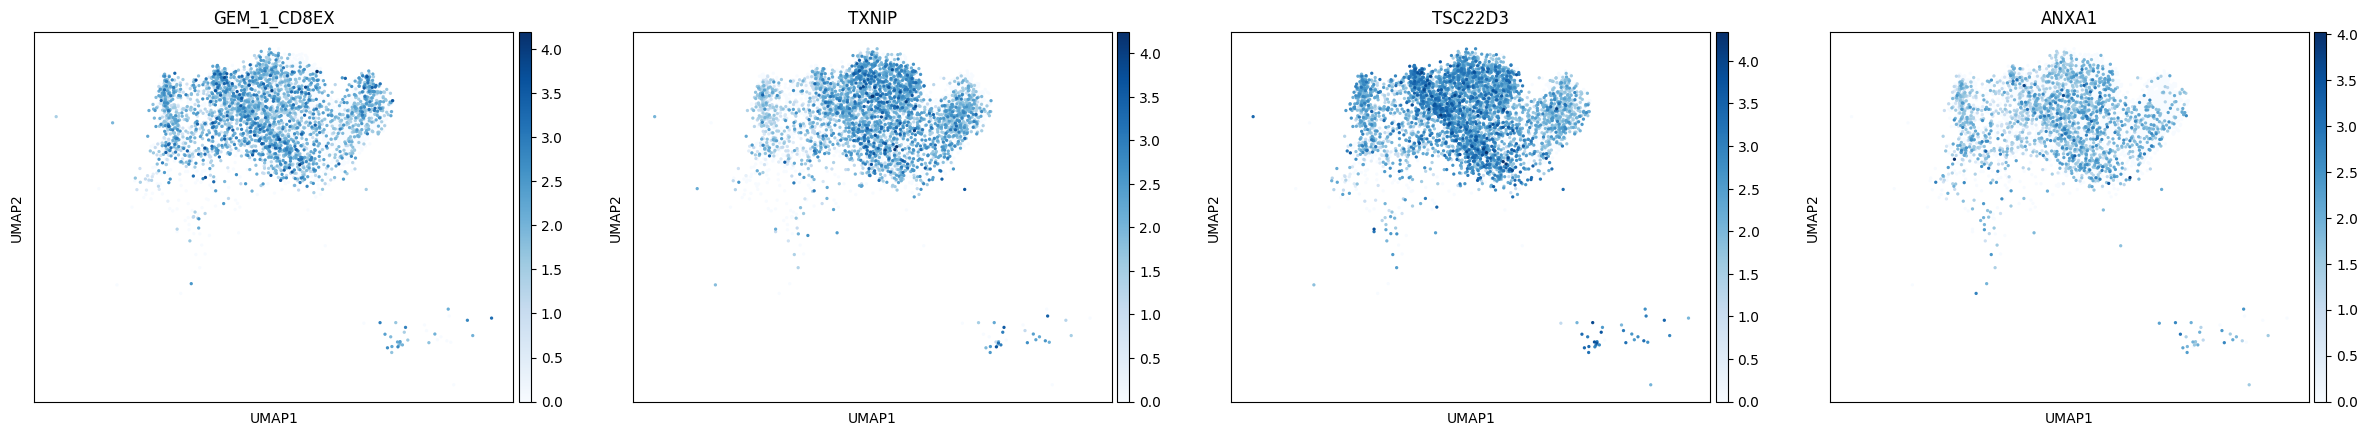

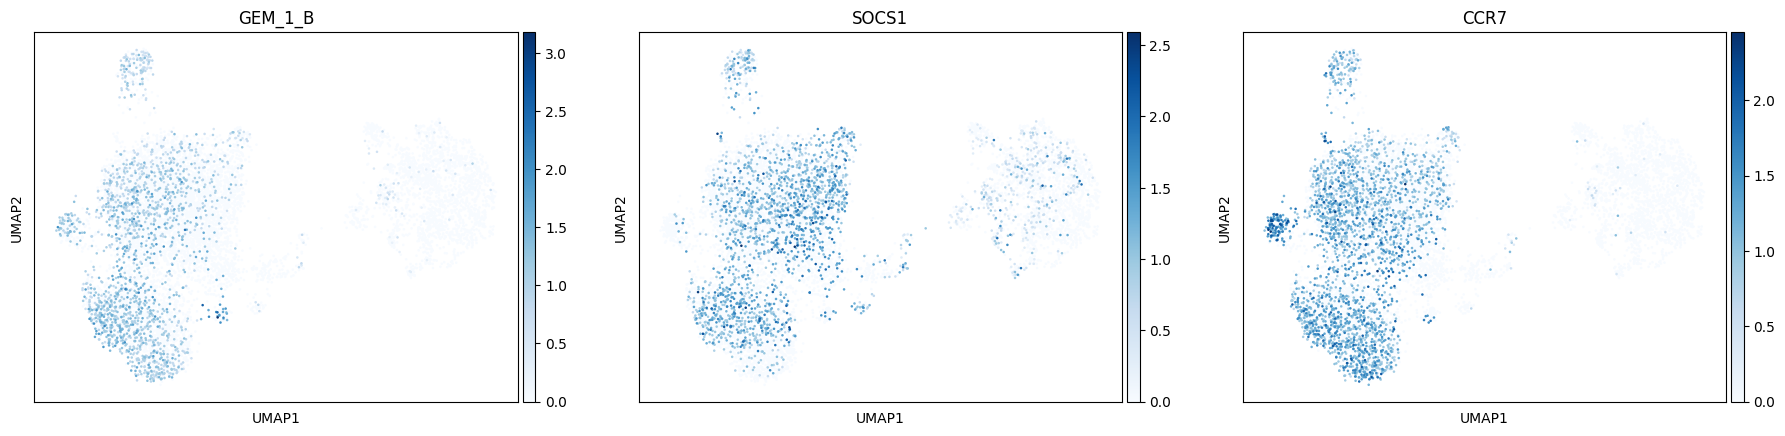

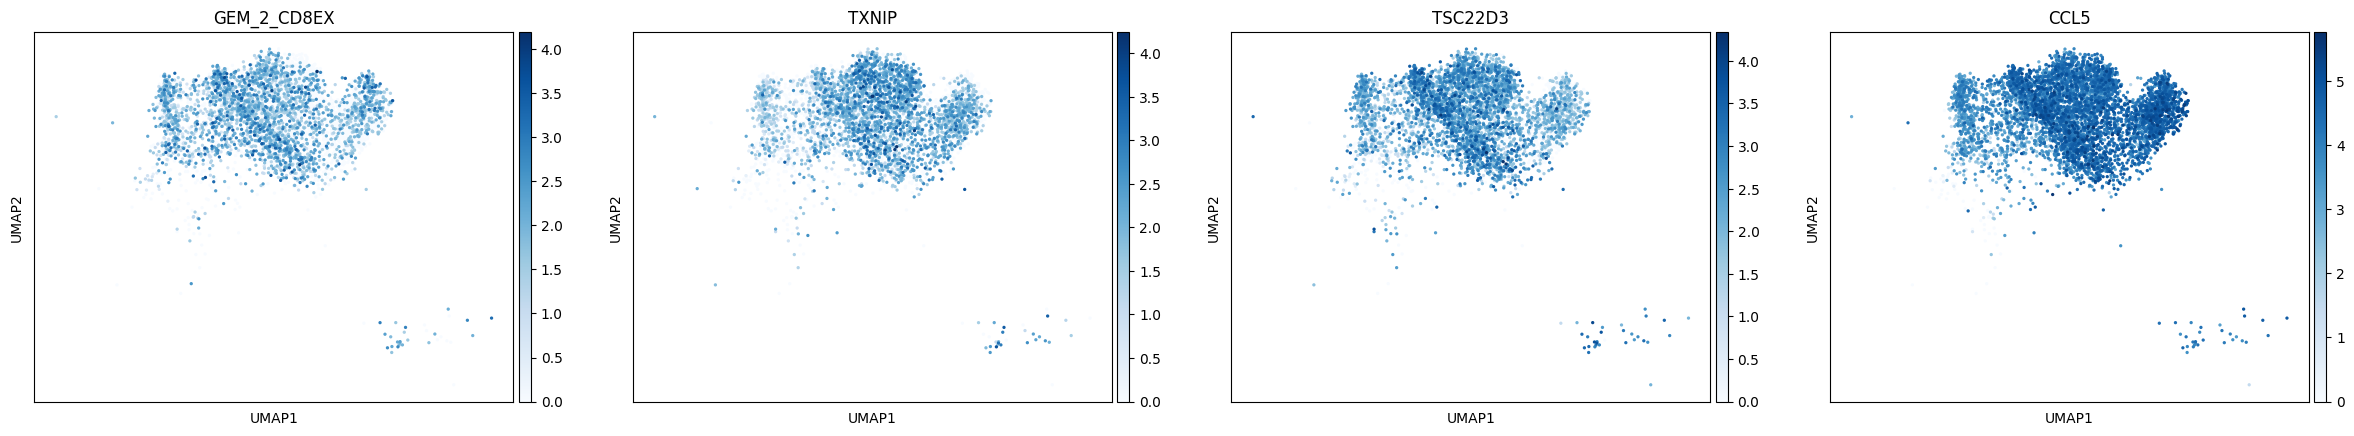

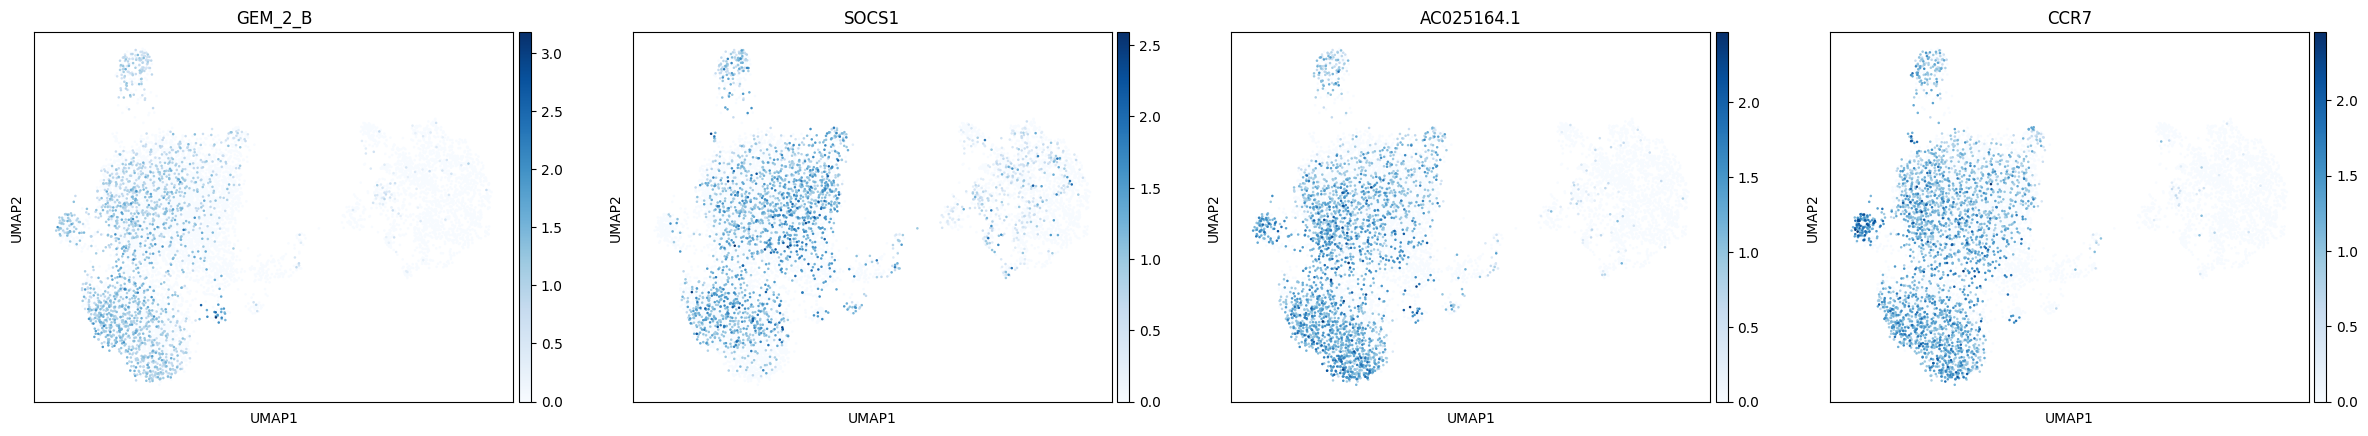

In [20]:
for i in range(1, len(DEG_pairs)+1):
    GEM_1 = DEG_pairs.loc[i, 'GEM_g1']
    # include the ligand to the GEM_1
    GEM_1.append(DEG_pairs.loc[i, 'Ligand'])
    GEM_2 = DEG_pairs.loc[i, 'GEM_g2']
    # include the receptor to the GEM_2 if it is not 'FPR1/FPR3'
    GEM_2.append(DEG_pairs.loc[i, 'Receptor'])
    sc.pl.umap(adata_1, color=GEM_1, title='GEM_' + str(i) + '_CD8EX', cmap='Blues')
    sc.pl.umap(adata_2, color=GEM_2, title='GEM_' + str(i) + '_B', cmap='Blues')

### add GEM to adata and gene_df

In [21]:
# add GEM_1_T, GEM_2_T and so on to adata
for i in range(1, len(DEG_pairs)+1):
    GEM_1 = DEG_pairs.loc[i, 'GEM_g1']
    GEM_2 = DEG_pairs.loc[i, 'GEM_g2']
    # add GEMs to adata_1_pseudo and adata_2_pseudo
    adata_1_pseudo.obs['GEM_' + str(i) + '_CD8EX'] = adata_1_pseudo[:, GEM_1].X.mean(axis=1)
    adata_2_pseudo.obs['GEM_' + str(i) + '_B'] = adata_2_pseudo[:, GEM_2].X.mean(axis=1)
    # add GEMs to adata_1 and adata_2
    adata_1.obs['GEM_' + str(i) + '_CD8EX'] = adata_1[:, GEM_1].X.mean(axis=1)
    adata_2.obs['GEM_' + str(i) + '_B'] = adata_2[:, GEM_2].X.mean(axis=1)

In [22]:

# Apply the function to the GEM_g1 column to add '_T' to each gene name
DEG_pairs['GEM_g1'] = DEG_pairs['GEM_g1'].apply(lambda x: append_suffix(x, '_CD8EX'))

# Similarly for GEM_g2 if needed
DEG_pairs['GEM_g2'] = DEG_pairs['GEM_g2'].apply(lambda x: append_suffix(x, '_B'))

# Check the results
print(DEG_pairs['GEM_g1'].head())
print(DEG_pairs['GEM_g2'].head())


1    [NFKBIA_CD8EX, TXNIP_CD8EX, TSC22D3_CD8EX, ANX...
2    [NFKBIA_CD8EX, TXNIP_CD8EX, TSC22D3_CD8EX, CCL...
Name: GEM_g1, dtype: object
1                  [CEMIP2_B, SOCS1_B, CCR7_B]
2    [CEMIP2_B, SOCS1_B, AC025164.1_B, CCR7_B]
Name: GEM_g2, dtype: object


/tmp/ipykernel_755996/2943153687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DEG_pairs['GEM_g1'] = DEG_pairs['GEM_g1'].apply(lambda x: append_suffix(x, '_CD8EX'))
/tmp/ipykernel_755996/2943153687.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DEG_pairs['GEM_g2'] = DEG_pairs['GEM_g2'].apply(lambda x: append_suffix(x, '_B'))


### show the GEM UMAP 

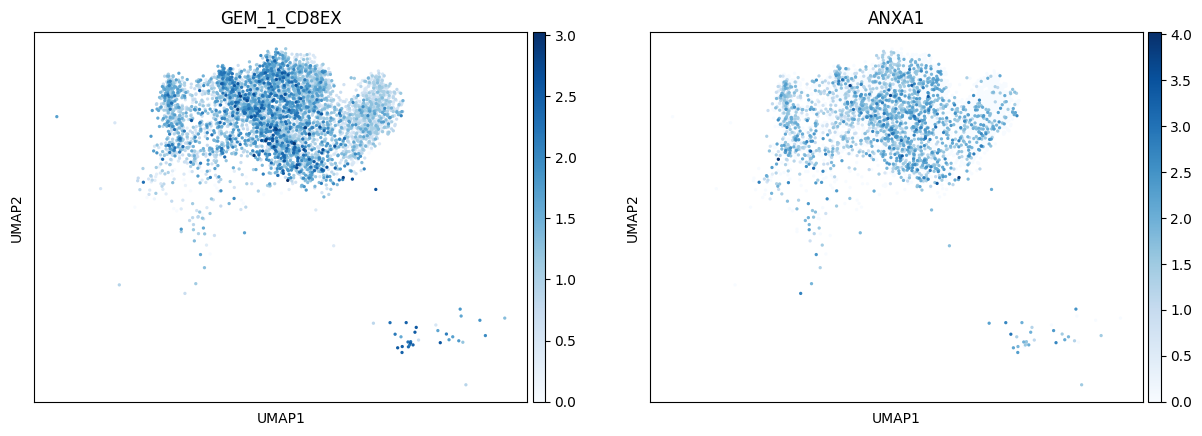

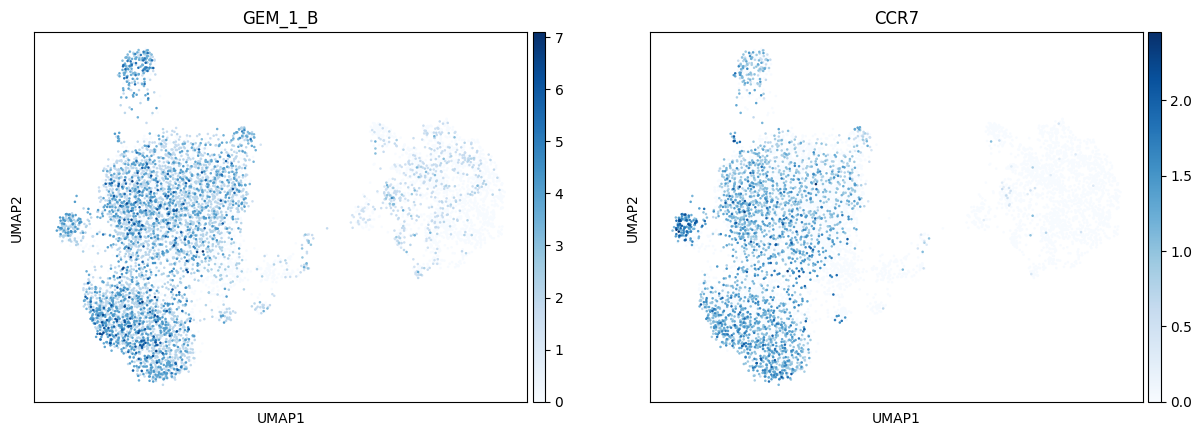

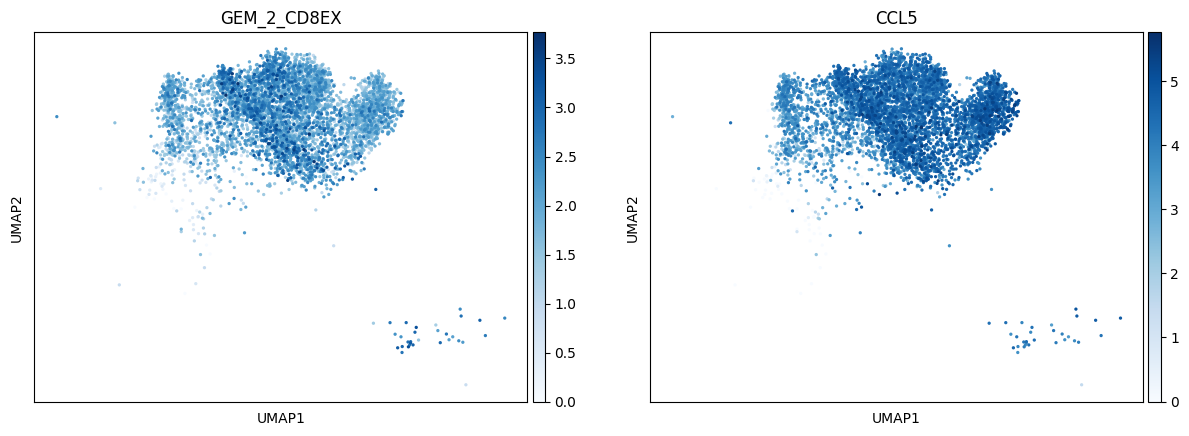

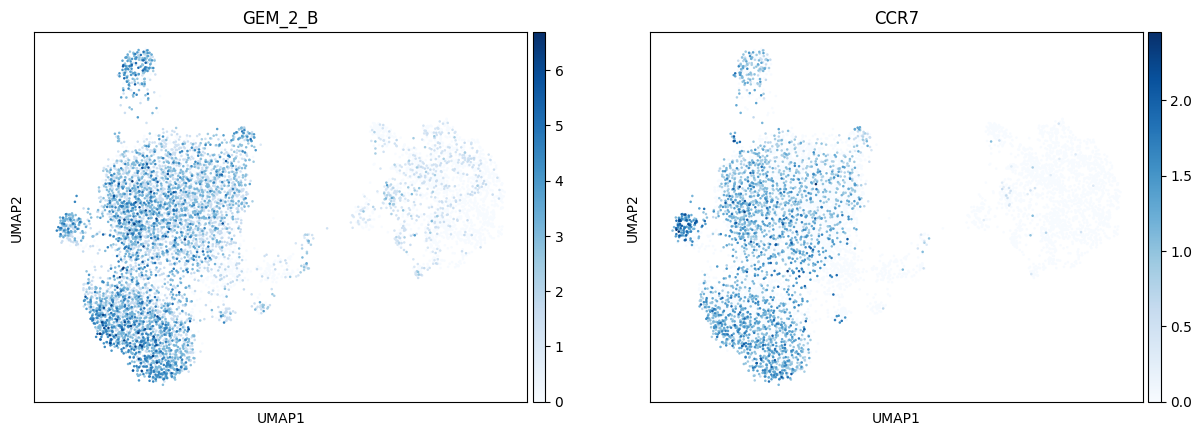

In [23]:
# plot the UMAP of GEMs
for i in range(1, len(DEG_pairs)+1):
    GEM_1 = DEG_pairs.loc[i, 'GEM_g1']
    GEM_2 = DEG_pairs.loc[i, 'GEM_g2']
    L = DEG_pairs.loc[i, 'Ligand']
    R = DEG_pairs.loc[i, 'Receptor']
    sc.pl.umap(adata_1, color=['GEM_' + str(i) + '_CD8EX', L], title='GEM_' + str(i) + '_CD8EX', cmap='Blues')
    sc.pl.umap(adata_2, color=['GEM_' + str(i) + '_B', R], title='GEM_' + str(i) + '_B', cmap='Blues')

### calculate the corr and CIT

In [24]:
# create the g1 columns in the results data filled with 'GEM_1_T', 'GEM_2_T' and so on in results dataframe not DEGpairs
results['g1'] = 'GEM_' + results.index.astype(str) + '_CD8EX'
results['g2'] = 'GEM_' + results.index.astype(str) + '_B'
results

,Unnamed: 0,Ligand,Receptor,GEM_g1,GEM_g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1,g2
1,0,ANXA1,CCR7,"['NFKBIA', 'TXNIP', 'TSC22D3']","['CEMIP2', 'SOCS1']",3,2,[1],[1],GEM_1_CD8EX,GEM_1_B
2,1,CCL5,CCR7,"['NFKBIA', 'TXNIP', 'TSC22D3']","['CEMIP2', 'SOCS1', 'AC025164.1']",3,3,[0],[0],GEM_2_CD8EX,GEM_2_B


In [25]:
def calculate_GEM_correlation(results, adata_1_pseudo, adata_2_pseudo, method='pearson'):
    if method not in ['pearson', 'spearman']:
        raise ValueError("Method must be either 'pearson' or 'spearman'")
    
    results['g1vsg2_correlation'] = 0

    for index, row in results.iterrows():
        g1 = row['g1']
        g2 = row['g2']

        g1_data = adata_1_pseudo.obs[g1]
        g1_df = pd.DataFrame(g1_data, columns=[g1], index=adata_1_pseudo.obs['sample_id'])
        g1_df = g1_df.dropna()

        g2_data = adata_2_pseudo.obs[g2]
        g2_df = pd.DataFrame(g2_data, columns=[g2], index=adata_2_pseudo.obs['sample_id'])
        g2_df = g2_df.dropna()

        if method == 'pearson':
            corr_g1_g2 = pearsonr(g1_df[g1], g2_df[g2])[0]
        elif method == 'spearman':
            corr_g1_g2 = spearmanr(g1_df[g1], g2_df[g2])[0]

        results.loc[index, 'g1vsg2_correlation'] = corr_g1_g2
    
    return results


import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

def calculate_residuals_GEM_correlation(results, adata_T_pseudo, adata_M_pseudo, method='pearson'):
    results['g1_residualvsg2_residuals_correlation'] = 0

    for index, row in results.iterrows():
        g1 = row['g1']
        g2 = row['g2']
        L = row['Ligand']
        R = row['Receptor']

        if g1 not in adata_T_pseudo.obs.columns or g2 not in adata_M_pseudo.obs.columns:
            continue

        g1_T = adata_T_pseudo.obs[g1].values.flatten()
        g2_M = adata_M_pseudo.obs[g2].values.flatten()
        L_T = adata_T_pseudo[:, L].X.toarray().flatten()
        R_M = adata_M_pseudo[:, R].X.toarray().flatten()

        L_R = L_T * R_M

        df_g1 = pd.DataFrame({g1: g1_T, 'L*R': L_R})
        df_g2 = pd.DataFrame({g2: g2_M, 'L*R': L_R})
        df_g1 = df_g1.dropna()
        df_g2 = df_g2.dropna()

        X_g1 = sm.add_constant(df_g1['L*R'])
        y_g1 = df_g1[g1]
        model_g1 = sm.OLS(y_g1, X_g1).fit()
        residuals_g1 = model_g1.resid

        X_g2 = sm.add_constant(df_g2['L*R'])
        y_g2 = df_g2[g2]
        model_g2 = sm.OLS(y_g2, X_g2).fit()
        residuals_g2 = model_g2.resid

        if method == 'pearson':
            corr = pearsonr(residuals_g1, residuals_g2)[0]
        elif method == 'spearman':
            corr = spearmanr(residuals_g1, residuals_g2)[0]

        results.at[index, 'g1_residualvsg2_residuals_correlation'] = corr

    return results


In [26]:
results

,Unnamed: 0,Ligand,Receptor,GEM_g1,GEM_g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1,g2
1,0,ANXA1,CCR7,"['NFKBIA', 'TXNIP', 'TSC22D3']","['CEMIP2', 'SOCS1']",3,2,[1],[1],GEM_1_CD8EX,GEM_1_B
2,1,CCL5,CCR7,"['NFKBIA', 'TXNIP', 'TSC22D3']","['CEMIP2', 'SOCS1', 'AC025164.1']",3,3,[0],[0],GEM_2_CD8EX,GEM_2_B


In [27]:
# remove '-0' and '-1' in adata_1_pseudo.obs.index
adata_1_pseudo.obs.index = [i.split('-')[0] for i in adata_1_pseudo.obs.index]
adata_2_pseudo.obs.index = [i.split('-')[0] for i in adata_2_pseudo.obs.index]

In [28]:
# calculate the correlation between GEMs
calculate_GEM_correlation(results, adata_1_pseudo, adata_2_pseudo)
calculate_residuals_GEM_correlation(results, adata_1_pseudo, adata_2_pseudo)

,Unnamed: 0,Ligand,Receptor,GEM_g1,GEM_g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1,g2,g1vsg2_correlation,g1_residualvsg2_residuals_correlation
1,0,ANXA1,CCR7,"['NFKBIA', 'TXNIP', 'TSC22D3']","['CEMIP2', 'SOCS1']",3,2,[1],[1],GEM_1_CD8EX,GEM_1_B,0.352022,-0.171000
2,1,CCL5,CCR7,"['NFKBIA', 'TXNIP', 'TSC22D3']","['CEMIP2', 'SOCS1', 'AC025164.1']",3,3,[0],[0],GEM_2_CD8EX,GEM_2_B,0.256392,-0.133861


In [29]:
DEG_pairs = results[['Ligand', 'Receptor', 'g1', 'g2']]
for index, row in DEG_pairs.iterrows():
    L = row['Ligand']
    R = row['Receptor']
    g1 = row['g1']
    g2 = row['g2']
    L_T = adata_1_pseudo[:, L].X
    L_T = pd.DataFrame(L_T, columns=[L], index=adata_1_pseudo.obs['sample_id']).dropna()
    R_M = adata_2_pseudo[:, R].X
    R_M = pd.DataFrame(R_M, columns=[R], index=adata_2_pseudo.obs['sample_id']).dropna()
                    
    # Calculate L*R
    L_T.columns = [R + '_vs_' + L]
    R_M.columns = L_T.columns
    L_R = L_T.multiply(R_M, axis=0).iloc[:, 0]

    g1_T = adata_1_pseudo.obs[g1]
    g2_M = adata_2_pseudo.obs[g2]
    df = pd.DataFrame({g1: g1_T, g2: g2_M, 'L*R': L_R}).dropna()

                    # Convert df to numpy array
    df_numpy = df.to_numpy()
    cit_obj = CIT(df_numpy, "fisherz")
    pValue = cit_obj(0, 1, [2])
    results.at[index, 'p_value_fisherz'] = pValue
# remove the columns with 'Unnamed'
results = results.loc[:, ~results.columns.str.contains('^Unnamed')]
results

,Ligand,Receptor,GEM_g1,GEM_g2,Num_genes_g1,Num_genes_g2,Overlapping_g1,Overlapping_g2,g1,g2,g1vsg2_correlation,g1_residualvsg2_residuals_correlation,p_value_fisherz
1,ANXA1,CCR7,"['NFKBIA', 'TXNIP', 'TSC22D3']","['CEMIP2', 'SOCS1']",3,2,[1],[1],GEM_1_CD8EX,GEM_1_B,0.352022,-0.171000,0.188436
2,CCL5,CCR7,"['NFKBIA', 'TXNIP', 'TSC22D3']","['CEMIP2', 'SOCS1', 'AC025164.1']",3,3,[0],[0],GEM_2_CD8EX,GEM_2_B,0.256392,-0.133861,0.305074


In [30]:
# save results
results.to_excel('/home/qiuaodon/Desktop/project_data_new/grouped_GEM_CD8EXvsB_fisherz_final.xlsx')

### plot scatter diagram show corr

In [35]:
def plot_CIT_1DEGcorr(g1, g2, L, R, DEG_exp, pseudo_1, pseudo_2):
    # Define a custom palette
    palette = {'pre': "#E69F00", 'on': "#56B4E9"}
    #replace the treatment column 0 pre and 1 on
    DEG_exp['treatment'] = DEG_exp['treatment'].replace({0: 'pre', 1: 'on'})
    # Set font sizes
    title_fontsize = 14
    axis_fontsize = 14
    legend_fontsize = 12

    def adjust_plot_limits(ax, x_data, y_data):
        x_min, x_max = x_data.min(), x_data.max()
        y_min, y_max = y_data.min(), y_data.max()
        x_padding = (x_max - x_min) * 0.1
        y_padding = (y_max - y_min) * 0.1
        ax.set_xlim(x_min - x_padding, x_max + x_padding)
        ax.set_ylim(y_min - y_padding, y_max + y_padding)

    # Plot the jointplot between DEG of g1 and g2
    g1_exp = adata_1_pseudo.obs[g1]
    g2_exp = adata_2_pseudo.obs[g2]
    df1 = pd.DataFrame({g1: g1_exp, g2: g2_exp, 'treatment': DEG_exp['treatment']})
    df1 = df1.dropna()
    g = sns.jointplot(x=g1, y=g2, data=df1, hue='treatment', palette=palette, kind='scatter', marginal_kws=dict(fill=True))
    sns.regplot(x=g1, y=g2, data=df1, scatter=False, ax=g.ax_joint, color='black')
    adjust_plot_limits(g.ax_joint, df1[g1], df1[g2])
    # limit y to -100-5000
    g.ax_joint.set_ylim(-100, 5000)
    

    
    g.ax_joint.tick_params(left=False, bottom=False)
    g.ax_marg_x.tick_params(bottom=False)
    g.ax_marg_y.tick_params(left=False)
    cor = pearsonr(df1[g1], df1[g2])[0]
    plt.suptitle(f'Correlation between {g1} and {g2} is {cor:.3f}', fontsize=title_fontsize)
    plt.subplots_adjust(top=0.9)
    plt.show()

     # Plot the jointplot between DEG of g1 and g2 residue
    L_values = pseudo_1[:, L].X.toarray().flatten()
    R_values = pseudo_2[:, R].X.toarray().flatten()
    L_R = L_values * R_values
    X = sm.add_constant(L_R)

    # Fit OLS model for g2
    model_g2 = sm.OLS(g2_exp, X).fit()
    residuals_g2 = model_g2.resid

    # Fit OLS model for g1
    model_g1 = sm.OLS(g1_exp, X).fit()
    residuals_g1 = model_g1.resid

    #   Create DataFrame for residuals
    df_res = pd.DataFrame({
        'G_1_residual': residuals_g1,
        'G_2_residual': residuals_g2,
        'treatment': DEG_exp['treatment']
    })

    # Plot the residuals
    g = sns.jointplot(x='G_1_residual', y='G_2_residual', data=df_res, hue='treatment', palette=palette, kind='scatter', marginal_kws=dict(fill=True))
    sns.regplot(x='G_1_residual', y='G_2_residual', data=df_res, scatter=False, ax=g.ax_joint, color='black')

    # Adjust plot limits if needed
    adjust_plot_limits(g.ax_joint, df_res['G_1_residual'], df_res['G_2_residual'])

    # Customize plot appearance
    g.ax_joint.tick_params(left=False, bottom=False)
    g.ax_marg_x.tick_params(bottom=False)
    g.ax_marg_y.tick_params(left=False)

    # Calculate and display correlation
    corr_res = pearsonr(df_res['G_1_residual'], df_res['G_2_residual'])[0]
    plt.suptitle(f'Correlation between residuals of G_1 and G_2 is {corr_res:.3f}', fontsize=title_fontsize)
    plt.subplots_adjust(top=0.9)
    plt.show()


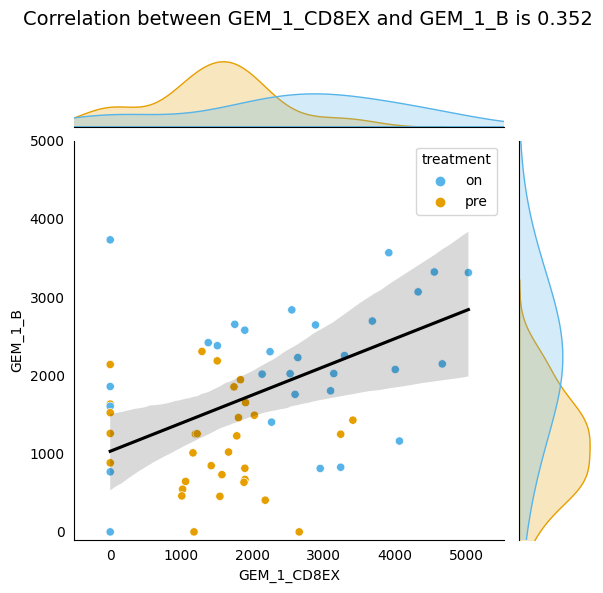

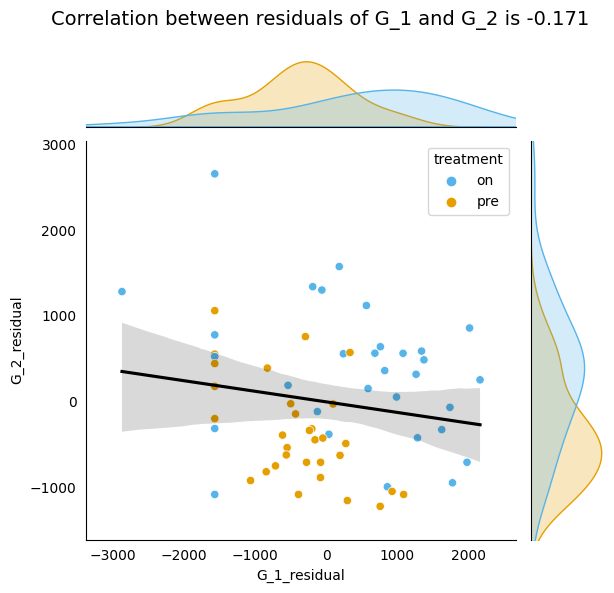

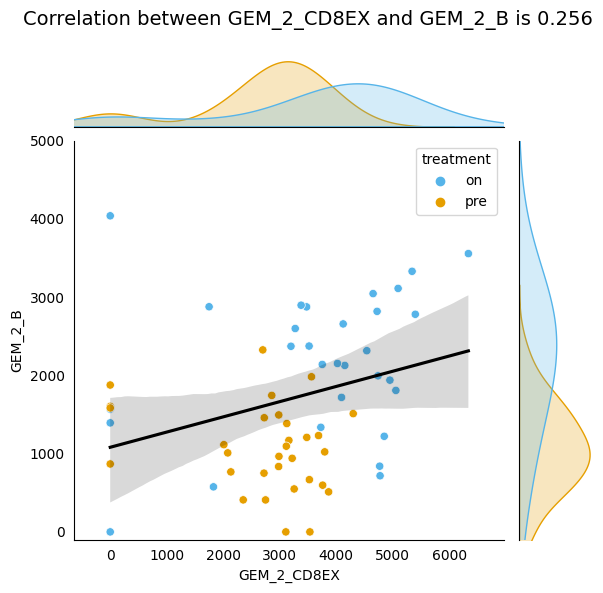

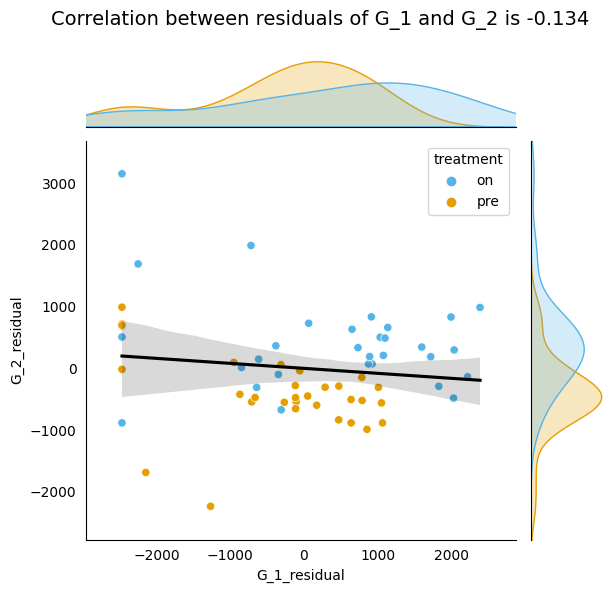

In [36]:
# plot the scatter plot of GEMs use plot_CIT_DEGcorr
for index, row in DEG_pairs.iterrows():
    g1 = row['g1']
    g2 = row['g2']
    L = row['Ligand']
    R = row['Receptor']
    plot_CIT_1DEGcorr(g1, g2, L, R, gene_df, adata_1_pseudo, adata_2_pseudo)
### if the corr is different, it is becuase the value from gene_df and adata_1_pseudo and adata_2_pseudo are different